In [190]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from collections import Counter
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.style as mplstyle
import matplotlib.patches as mpatches
from matplotlib.ticker import (PercentFormatter,MultipleLocator, AutoMinorLocator)
import seaborn as sns

In [332]:
conn = psycopg2.connect(database="postgres",
                        host="pklmartdb.ckkvdwandqoa.us-east-1.rds.amazonaws.com",
                        user="cmcnicholas",
                        password="momentum101",
                        port="5432")
conn.autocommit = True

In [192]:
def pullawsdata2(tablename):
    pdict = {"rally":{"query":"SELECT game_id, rally_id, rally_nbr, srv_team_id, w_team_id, to_team_id FROM pklm_prd.rally;", \
             "cols":['game_id', 'rally_id', 'rally_nbr', 'srv_team_id', 'w_team_id', 'to_team_id']}, \
    "team":{"query":"SELECT team_id,team_nm FROM pklm_prd.team;", \
             "cols": ['team_id','team_nm']}, \
    "game":{"query":"SELECT match_id,game_id,game_nbr,score_w,score_l,w_team_id,l_team_id,skill_lvl,vod_url FROM pklm_prd.game;", \
             "cols":['match_id','game_id','game_nbr','score_w','score_l','w_team_id','l_team_id','skill_lvl','vod_url']}}
    qry = pdict[tablename]["query"]
    cls = pdict[tablename]["cols"]
    
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(qry)
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=cls))
        except Exception as inst:
            print(f"inst \t type: {type(inst)} \t args: {inst.args}\n")     

In [193]:
def pullrally():
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(f"SELECT game_id, rally_id, rally_nbr, srv_team_id, w_team_id, to_team_id FROM pklm_prd.rally;")
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=['game_id', 'rally_id', 'rally_nbr', 'srv_team_id', 'w_team_id', 'to_team_id']))
        except Exception as inst:
            print(type(inst))    
            print(inst.args)     
            print(inst)

In [194]:
def pullgame():
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(f"SELECT match_id,game_id,game_nbr,score_w,score_l,w_team_id,l_team_id,skill_lvl FROM pklm_prd.game;")
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=['match_id','game_id','game_nbr','score_w','score_l','w_team_id','l_team_id','skill_lvl']))
        except Exception as inst:
            print(type(inst))    
            print(inst.args)     
            print(inst)

In [195]:
def pullteam():
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(f"SELECT team_id,team_nm FROM pklm_prd.team;")
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=['team_id','team_nm']))
        except Exception as inst:
            print(type(inst))    
            print(inst.args)     
            print(inst)

In [196]:
rally=pullrally()
rally['game_id'] = [int(x[1:]) for x in rally.game_id]
rally['rally_id'] = [int(x[1:]) for x in rally.rally_id]
rally = rally.sort_values(['game_id', 'rally_id', 'rally_nbr']).reset_index(drop=True)

In [197]:
game=pullgame()
game['game_id'] = [int(x[1:]) for x in game.game_id]
game['match_id'] = [int(x[1:]) for x in game.match_id]
game.skill_lvl.iloc[game.skill_lvl == '4'] = '4.0'
game.skill_lvl.iloc[game.skill_lvl == '5'] = '5.0'
game = game.sort_values(['match_id','game_id']).reset_index(drop=True)

In [198]:
played = rally.query('to_team_id == "N/A"')
srv_win = round(100*len(played[played.srv_team_id == played.w_team_id])/len(played),2)
ret_win = round(100*len(played[played.srv_team_id != played.w_team_id])/len(played),2)
print(f'serving team wins {srv_win}% of the {len(played)} rallies')
print(f'returning team wins {ret_win}% of the {len(played)} rallies')

serving team wins 42.94% of the 30469 rallies
returning team wins 57.06% of the 30469 rallies


In [199]:
skills = sorted(list(game.skill_lvl.unique()))

In [200]:
skills

['2.5', '3.0', '3.5', '4.0', '4.5', '5.0', '5.5', 'Pro', 'Senior Pro']

In [201]:
dskill = {}
for sk in skills:
    print(f"skill = {sk}")
    skillgame = game[game['skill_lvl'] == sk]['game_id']
    skillrally = rally.loc[rally.game_id.isin(skillgame)][lambda x:x.to_team_id == "N/A"]
    print(f"\t# games at skill = {len(skillgame)}")
    print(f"\t# rallies at skill = {len(skillrally)}")
    srv_win_skill = round(100*len(skillrally[skillrally.srv_team_id == skillrally.w_team_id])/len(skillrally),2)
    ret_win_skill = round(100*len(skillrally[skillrally.srv_team_id != skillrally.w_team_id])/len(skillrally),2)
    print(f'\n\t\tserving team wins {srv_win_skill}% of the {len(skillrally)} rallies')
    print(f'\t\treturning team wins {ret_win_skill}% of the {len(skillrally)} rallies\n\n')
    dskill[sk] = {"srv":srv_win_skill,"ret":ret_win_skill}

skill = 2.5
	# games at skill = 4
	# rallies at skill = 143

		serving team wins 48.25% of the 143 rallies
		returning team wins 51.75% of the 143 rallies


skill = 3.0
	# games at skill = 18
	# rallies at skill = 703

		serving team wins 45.66% of the 703 rallies
		returning team wins 54.34% of the 703 rallies


skill = 3.5
	# games at skill = 49
	# rallies at skill = 2062

		serving team wins 41.85% of the 2062 rallies
		returning team wins 58.15% of the 2062 rallies


skill = 4.0
	# games at skill = 190
	# rallies at skill = 8466

		serving team wins 41.57% of the 8466 rallies
		returning team wins 58.43% of the 8466 rallies


skill = 4.5
	# games at skill = 86
	# rallies at skill = 3505

		serving team wins 44.82% of the 3505 rallies
		returning team wins 55.18% of the 3505 rallies


skill = 5.0
	# games at skill = 110
	# rallies at skill = 4974

		serving team wins 42.92% of the 4974 rallies
		returning team wins 57.08% of the 4974 rallies


skill = 5.5
	# games at skill = 8
	# ra

In [305]:
50/ret_win

0.8762705923589204

In [303]:
winpct - retpct*(1-50/ret_win)

87.62705923589203

In [286]:
for x in [0,.25,.5,.75,1]:
    print(x-(1-(50/ret_win)))

-0.12372940764107965
0.12627059235892035
0.37627059235892035
0.6262705923589204
0.8762705923589204


In [386]:
def scoped(scope):
    scopelist=[]
    glist = list(rally.game_id.unique())
    dlist = []
    b2bl = []
    adj = 0
    for i in range(len(glist)):
        gi = rally[rally.game_id==glist[i]].reset_index(drop=True)
        to_game = glist[i]
        to_inds = list(gi.index[gi.to_team_id != 'N/A'])
        to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
        backtoback = [todelta==1 for todelta in [x-y for x,y in zip(to_inds[1:],to_inds[:-1])]]
        if np.any(backtoback):
            #print(f'\n\tgame: {to_game} has timeouts in consecutive rallies')
            b2bl.append(to_game)
            backtoback.append(False)
            gi = gi.drop(list(np.array(to_inds)[backtoback])).reset_index(drop=True)
            to_inds = list(gi.index[gi.to_team_id != 'N/A'])
            to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
        skill_lvl = list(game.skill_lvl[game.game_id == glist[i]])[0]
        if (len(to_inds) > 0):
            for j in range(len(to_inds)):
                if j == 0:
                    pre = list(range(to_inds[j]))
                else:
                    pre = list(range(to_inds[j-1]+1,to_inds[j]))
                if j == len(to_inds)-1:
                    post = list(range(to_inds[j]+1,len(gi)))
                else:
                    post = list(range(to_inds[j]+1,to_inds[j+1]))
                toteam = to_teams[j]
                rallynbr = gi.rally_nbr.iloc[to_inds[j]]        
                rallyid = gi.rally_id.iloc[to_inds[j]]

                if len(pre) >= scope and len(post) >= scope:
                    prescope = pre[:scope]
                    postscope = post[:scope]
                    winprescope = round(100*len(gi.iloc[prescope][lambda x:x.w_team_id == toteam])/scope,1)
                    winpostscope = round(100*len(gi.iloc[postscope][lambda x:x.w_team_id == toteam])/scope,1)
                    windeltascope = round(winpostscope-winprescope,1)
                
                    retpctpre=len(gi.iloc[prescope][lambda x:x.srv_team_id != toteam])/scope
                    retpctpost=len(gi.iloc[postscope][lambda x:x.srv_team_id != toteam])/scope

                    winprescope_adj = winprescope-(100*retpctpre*(1-50/ret_win))
                    winpostscope_adj = winpostscope-(100*retpctpost*(1-50/ret_win))
                    windeltascope_adj = round(winpostscope_adj-winprescope_adj,1)
                    scopelist.append([to_game,skill_lvl,j+1,toteam,rallynbr,windeltascope,windeltascope_adj])

    df_scope = pd.DataFrame(scopelist,columns=['game_id','skill_lvl','to_nbr','to_team','rally_nbr','deltawin','deltawin_adj'])
    return df_scope
    #return df_scope[['windeltascope','windeltascope_adj']].agg(['count','mean','median','max','min','std']).round(1)

In [316]:
glist = list(rally.game_id.unique())
dlist = []
b2bl = []
for i in range(len(glist)):
    gi = rally[rally.game_id==glist[i]].reset_index(drop=True)
    to_game = glist[i]
    to_inds = list(gi.index[gi.to_team_id != 'N/A'])
    to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
    backtoback = [todelta==1 for todelta in [x-y for x,y in zip(to_inds[1:],to_inds[:-1])]]
    if np.any(backtoback):
        #print(f'\n\tgame: {to_game} has timeouts in consecutive rallies')
        b2bl.append(to_game)
        backtoback.append(False)
        gi = gi.drop(list(np.array(to_inds)[backtoback])).reset_index(drop=True)
        to_inds = list(gi.index[gi.to_team_id != 'N/A'])
        to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
    skill_lvl = list(game.skill_lvl[game.game_id == glist[i]])[0]
    if (len(to_inds) > 0):
        for j in range(len(to_inds)):
            if j == 0:
                pre = list(range(to_inds[j]))
            else:
                pre = list(range(to_inds[j-1]+1,to_inds[j]))
            if j == len(to_inds)-1:
                post = list(range(to_inds[j]+1,len(gi)))
            else:
                post = list(range(to_inds[j]+1,to_inds[j+1]))
            toteam = to_teams[j]
            rallynbr = gi.rally_nbr.iloc[to_inds[j]]        
            
            winpre = round(100*len(gi.iloc[pre][lambda x:x.w_team_id == toteam])/len(pre),1)
            winpost = round(100*len(gi.iloc[post][lambda x:x.w_team_id == toteam])/len(post),1)
            windelta = round(winpost-winpre,1)
            
            srvpre = gi.iloc[pre][lambda x:x.srv_team_id == toteam]
            rcvpre = gi.iloc[pre][lambda x:x.srv_team_id != toteam]

            srvlenpre=len(srvpre)
            rcvlenpre=len(rcvpre)
            
            srvpost = gi.iloc[post][lambda x:x.srv_team_id == toteam]
            rcvpost = gi.iloc[post][lambda x:x.srv_team_id != toteam]

            srvlenpost=len(srvpost)
            rcvlenpost=len(rcvpost)
            
            if srvlenpre > 0:
                srvwinpre = round(100*len(srvpre.loc[lambda x:x.w_team_id == toteam])/srvlenpre,1)
            else:
                srvwinpre = None
            if srvlenpost > 0:
                srvwinpost = round(100*len(srvpost.loc[lambda x:x.w_team_id == toteam])/srvlenpost,1)
            else:
                srvwinpost = None
            if srvlenpre > 0 and srvlenpost > 0:
                srvwindelta = round(srvwinpost-srvwinpre,1)
            else:
                srvwindelta = None
                
            
            if rcvlenpre > 0:
                rcvwinpre = round(100*len(rcvpre.loc[lambda x:x.w_team_id == toteam])/rcvlenpre,1)
            else:
                rcvwinpre = None
            if rcvlenpost > 0:
                rcvwinpost = round(100*len(rcvpost.loc[lambda x:x.w_team_id == toteam])/rcvlenpost,1)
            else:
                rcvwinpost = None
            if rcvlenpre > 0 and rcvlenpost > 0:
                rcvwindelta = round(rcvwinpost-rcvwinpre,1)
            else:
                rcvwindelta = None
            
            winpre_adj = winpre-(100*(rcvlenpre/len(pre))*(1-(50/ret_win)))
            winpost_adj = winpost-(100*(rcvlenpost/len(post))*(1-(50/ret_win)))
            windelta_adj = round(winpost_adj-winpre_adj,1)

            dlist.append([to_game,skill_lvl,j+1,toteam,rallynbr,len(pre),len(post),windelta_adj,winpre,winpost,windelta,srvwinpre,srvwinpost,srvwindelta,rcvwinpre,rcvwinpost,rcvwindelta])

In [387]:
s = 25
srange = [scoped(z)[['deltawin','deltawin_adj']].agg(['count','mean','median','max','min','std']).round(1).to_dict() for z in range(2,s)]

In [388]:
smetrx= [x["deltawin"] for x in srange]
df_scoped = pd.DataFrame(smetrx)
df_scoped["scope"]=list(range(2,s))
df_scoped = df_scoped[['scope','count','mean','median','max','min','std']]

In [389]:
df_scoped

,scope,count,mean,median,max,min,std
0,2,367.0,6.9,0.0,100.0,-100.0,46.6
1,3,349.0,4.3,0.0,100.0,-100.0,34.6
2,4,331.0,1.3,0.0,75.0,-75.0,29.0
3,5,294.0,2.7,0.0,60.0,-60.0,25.2
4,6,263.0,2.9,0.0,66.6,-50.0,21.7
5,7,235.0,3.2,0.0,57.1,-42.9,19.9
6,8,204.0,1.5,0.0,50.0,-37.5,17.8
7,9,171.0,2.1,0.0,55.6,-33.4,18.4
8,10,146.0,2.5,0.0,50.0,-40.0,17.6
9,11,127.0,1.8,0.0,45.4,-36.3,16.2


In [390]:
smetrx_adj= [x["deltawin_adj"] for x in srange]
df_scoped_adj = pd.DataFrame(smetrx_adj)
df_scoped_adj["scope"]=list(range(2,s))
df_scoped_adj = df_scoped_adj[['scope','count','mean','median','max','min','std']]

In [391]:
df_scoped_adj

,scope,count,mean,median,max,min,std
0,2,367.0,3.5,0.0,106.2,-112.4,47.5
1,3,349.0,2.5,0.0,108.2,-108.2,36.4
2,4,331.0,0.3,0.0,75.0,-84.3,30.6
3,5,294.0,2.0,0.0,64.9,-64.9,27.1
4,6,263.0,2.2,0.0,68.7,-54.1,23.7
5,7,235.0,2.6,0.0,60.6,-48.2,21.7
6,8,204.0,1.0,0.0,53.1,-43.7,19.6
7,9,171.0,1.6,0.0,58.3,-38.9,20.1
8,10,146.0,2.2,0.0,52.5,-42.5,19.1
9,11,127.0,1.4,0.0,47.6,-38.5,17.5


In [392]:
df_scoped.mean().round(1)

scope      13.0
count     133.6
mean        3.2
median      2.2
max        45.8
min       -36.5
std        17.9
dtype: float64

In [393]:
df_scoped_adj.mean().round(1)

scope      13.0
count     133.6
mean        2.9
median      2.2
max        49.2
min       -40.4
std        19.3
dtype: float64

In [394]:
df_scoped.query(f'scope*count == {(df_scoped["count"]*df_scoped["scope"]).max()}')

,scope,count,mean,median,max,min,std
5,7,235.0,3.2,0.0,57.1,-42.9,19.9


In [395]:
df_scoped_adj.query(f'scope*count == {(df_scoped_adj["count"]*df_scoped_adj["scope"]).max()}')

,scope,count,mean,median,max,min,std
5,7,235.0,2.6,0.0,60.6,-48.2,21.7


In [396]:
df_timeout_7 = scoped(7)
df_timeout_7['to_id'] = ["TO"+str(x) for x in df_timeout_7.index]

In [327]:
df_timeout = pd.DataFrame(dlist,columns=['game_id','skill_lvl','to_nbr','to_team','rally_nbr','lenpre','lenpost','deltawin_adj', \
                                         'prewin','postwin','deltawin','prewinsrv','postwinsrv','deltawinsrv', \
                                         'prewinrcv','postwinrcv','deltawinrcv'])
df_timeout['to_id'] = ["TO"+str(x) for x in df_timeout.index]

In [397]:
print(f'timeout effectiveness metrics across all {len(df_timeout)} timeouts: \n')
df_timeout[['lenpre','lenpost','deltawin_adj','deltawin','deltawinsrv','deltawinrcv']].agg(['mean','median','max','min','std']).round(1). \
    rename(columns={'lenpre':'rlys_pre','lenpost':'rlys_post','deltawin_adj':'TOboost_adj','deltawin':'TOboost','deltawinsrv':'TOboost_srv','deltawinrcv':'TOboost_ret'})

timeout effectiveness metrics across all 389 timeouts: 



,rlys_pre,rlys_post,TOboost_adj,TOboost,TOboost_srv,TOboost_ret
mean,20.4,11.5,7.3,7.3,10.9,7.4
median,18.0,9.0,7.6,8.0,8.3,6.7
max,66.0,55.0,84.9,80.0,100.0,83.3
min,2.0,1.0,-71.5,-63.6,-66.7,-71.4
std,12.7,9.4,27.7,25.4,31.6,31.7


In [398]:
df_timeout_7 = scoped(7)
df_timeout_7['to_id'] = ["TO"+str(x) for x in df_timeout_7.index]

In [406]:
print(f'timeout effectiveness metrics using exactly 7 rallies before and after {len(df_timeout_7)} timeouts that accomodate the constraint: \n')
df_timeout_7[['deltawin_adj','deltawin']].agg(['mean','median','max','min','std']).round(1). \
    rename(columns={'deltawin_adj':'TOboost_adj','deltawin':'TOboost'})

timeout effectiveness metrics using exactly 7 rallies before and after 235 timeouts that accomodate the constraint: 



,TOboost_adj,TOboost
mean,2.6,3.2
median,0.0,0.0
max,60.6,57.1
min,-48.2,-42.9
std,21.7,19.9


In [403]:
df_timeout

,game_id,skill_lvl,to_nbr,to_team,rally_nbr,lenpre,lenpost,deltawin_adj,prewin,postwin,deltawin,prewinsrv,postwinsrv,deltawinsrv,prewinrcv,postwinrcv,deltawinrcv,to_id
0,1,Pro,1,T1,22,21,14,28.6,38.1,64.3,26.2,12.5,50.0,37.5,53.8,83.3,29.5,TO0
1,1,Pro,2,T2,37,14,12,-3.6,35.7,33.3,-2.4,16.7,0.0,-16.7,50.0,50.0,0.0,TO1
2,1,Pro,3,T2,50,12,10,38.8,33.3,70.0,36.7,0.0,60.0,60.0,50.0,80.0,30.0,TO2
3,1,Pro,4,T1,61,10,2,-36.2,30.0,0.0,-30.0,20.0,NaN,NaN,40.0,0.0,-40.0,TO3
4,2,Pro,1,T2,8,7,31,21.9,28.6,48.4,19.8,50.0,28.6,-21.4,20.0,64.7,44.7,TO4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,690,Pro,1,T549,16,15,9,-20.0,40.0,22.2,-17.8,50.0,0.0,-50.0,33.3,28.6,-4.7,TO384
385,715,Pro,1,T570,15,14,11,11.0,35.7,45.5,9.8,20.0,60.0,40.0,44.4,33.3,-11.1,TO385
386,715,Pro,2,T570,27,11,6,-13.7,45.5,33.3,-12.2,60.0,0.0,-60.0,33.3,50.0,16.7,TO386
387,739,5.0,1,T32,32,31,11,2.5,35.5,36.4,0.9,20.0,20.0,0.0,42.9,50.0,7.1,TO387


In [404]:
df_timeout_7

,game_id,skill_lvl,to_nbr,to_team,rally_nbr,deltawin,deltawin_adj,to_id
0,1,Pro,1,T1,22,28.5,30.3,TO0
1,1,Pro,2,T2,37,0.0,-3.5,TO1
2,1,Pro,3,T2,50,14.2,14.2,TO2
3,2,Pro,1,T2,8,28.5,32.0,TO3
4,4,Pro,1,T2,22,-14.2,-14.2,TO4
...,...,...,...,...,...,...,...,...
230,676,3.5,1,T522,23,0.0,0.0,TO230
231,690,Pro,1,T549,16,-42.8,-48.1,TO231
232,715,Pro,1,T570,15,14.2,19.5,TO232
233,739,5.0,1,T32,32,0.0,0.0,TO233


In [363]:
adj_delta = df_timeout.deltawin - df_timeout.deltawin_adj

In [366]:
adj_delta.agg(['mean','median','max','min','std']).round(2)

mean       0.08
median    -0.10
max       12.40
min       -7.20
std        3.07
dtype: float64

In [407]:
adj_delta_7 = df_timeout_7.deltawin - df_timeout_7.deltawin_adj
adj_delta_7.agg(['mean','median','max','min','std']).round(2)

mean      0.57
median    0.00
max       5.30
min      -7.10
std       2.54
dtype: float64

In [409]:
print('average timeout effectiveness by skill bracket: \n')
grouped = df_timeout_7.groupby('skill_lvl')
result = pd.concat([grouped['game_id'].agg([('games','nunique')]), \
                    grouped['game_id'].agg([('timeouts','count')]), \
                    grouped['deltawin_adj'].agg([('TOboost_adj','mean')]).round(1), \
                    grouped['deltawin'].agg([('TOboost','mean')]).round(1), \
                   ],axis=1).reset_index()
result['TOperGame'] = (result.timeouts/result.games).round(1)
result[['skill_lvl','games','timeouts','TOperGame','TOboost_adj','TOboost']]

average timeout effectiveness by skill bracket: 



,skill_lvl,games,timeouts,TOperGame,TOboost_adj,TOboost
0,3.5,4,5,1.2,-3.2,-2.9
1,4.0,9,12,1.3,-5.9,-4.7
2,4.5,17,21,1.2,2.5,3.4
3,5.0,38,46,1.2,3.0,3.7
4,5.5,2,2,1.0,7.1,7.1
5,Pro,114,147,1.3,3.6,4.1
6,Senior Pro,2,2,1.0,-23.2,-21.4


In [330]:
print('average timeout effectiveness by skill bracket: \n')
grouped = df_timeout.groupby('skill_lvl')
result = pd.concat([grouped['game_id'].agg([('games','nunique')]), \
                    grouped['game_id'].agg([('timeouts','count')]), \
                    grouped['lenpre'].agg([('rallys_prior','mean')]).round(1), \
                    grouped['lenpost'].agg([('rallys_after','mean')]).round(1), \
                    grouped['deltawin_adj'].agg([('TOboost_adj','mean')]).round(1), \
                    grouped['deltawin'].agg([('TOboost','mean')]).round(1), \
                    grouped['deltawinsrv'].agg([('TOboost_srv','mean')]).round(1), \
                    grouped['deltawinrcv'].agg([('TOboost_ret','mean')]).round(1), \
                   ],axis=1).reset_index()
result['TOperGame'] = (result.timeouts/result.games).round(1)
result[['skill_lvl','games','timeouts','TOperGame','rallys_prior','rallys_after','TOboost_adj','TOboost','TOboost_srv','TOboost_ret']]

average timeout effectiveness by skill bracket: 



,skill_lvl,games,timeouts,TOperGame,rallys_prior,rallys_after,TOboost_adj,TOboost,TOboost_srv,TOboost_ret
0,3.5,4,9,2.2,19.3,10.6,5.8,5.7,6.0,12.3
1,4.0,12,18,1.5,22.2,16.8,3.1,3.0,2.4,6.9
2,4.5,24,36,1.5,24.0,10.8,7.4,7.0,12.1,5.0
3,5.0,54,77,1.4,24.5,13.4,9.6,9.6,15.2,6.2
4,5.5,3,3,1.0,30.0,18.0,-8.8,-6.6,6.2,-3.8
5,Pro,144,241,1.7,18.5,10.7,7.2,7.4,10.2,8.4
6,Senior Pro,3,5,1.7,14.4,7.4,1.9,1.0,10.3,-12.9


In [333]:
team = pullteam()

In [336]:
df_wteam = game[['w_team_id','game_id']].groupby('w_team_id').count().reset_index(drop=False)
df_lteam = game[['l_team_id','game_id']].groupby('l_team_id').count().reset_index(drop=False)
df_wteam.columns=['team_id','W']
df_lteam.columns=['team_id','L']
#print(f"\ndf_wteam:\n {df_wteam.sort_values('team_id')}")
#print(f"\ndf_lteam:\n {df_lteam.sort_values('team_id')}")
#print(f'\nlength df_wteam: {len(df_wteam)} , length df_lteam: {len(df_lteam)}\n')

df_record = pd.merge(df_wteam,df_lteam,how='outer',on='team_id',sort=True).fillna(0)
df_record['GP'] = df_record.W+df_record.L
df_record['gameWpct'] = (100*df_record.W/df_record.GP).round(1)
df_record['Lpct'] = (100*df_record.L/df_record.GP).round(1)
#print(f"\ndf_record:\n {df_record}\n")
#print(f'\nlength df_record: {len(df_record)}\n')

df_tobyteam = df_timeout[['to_team','game_id']].groupby('to_team').count().reset_index(drop=False)
df_tobyteam.columns = ['team_id','TO']
df_tobyteam = df_tobyteam.sort_values('team_id')
#print(f"\ndf_tobyteam:\n {df_tobyteam}\n")
#print(f'\nlength df_tobyteam: {len(df_tobyteam)}\n')

df_teammetrx = pd.merge(df_record,df_tobyteam,how='outer',on='team_id').fillna(0)
df_teammetrx['TOperGame'] = (df_teammetrx.TO/df_teammetrx.GP).round(1)
#print(f"df_teammetrx:\n {df_teammetrx}\n")
#print(f'\nlength df_teammetrx: {len(df_teammetrx)}\n')

grouped = df_timeout.groupby('to_team')
df_teamcalc = pd.concat([grouped['deltawin'].agg([('TOboost','mean')]).round(1), \
                    grouped['deltawin_adj'].agg([('TOboost_adj','mean')]).round(1), \
                    grouped['deltawinsrv'].agg([('TOboost_srv','mean')]).round(1), \
                    grouped['deltawinrcv'].agg([('TOboost_ret','mean')]).round(1), \
                   ],axis=1).reset_index()
df_teamcalc.rename(columns={"to_team": "team_id"},inplace=True)
#print(f"\n df_teamcalc:\n {df_teamcalc}\n")
#print(f'\nlength df_teamcalc: {len(df_teamcalc)}\n')

df_teammetrx = pd.merge(df_teammetrx,df_teamcalc,how='outer',on='team_id').fillna(0)
df_teammetrx['team_id'] = [int(x[1:]) for x in df_teammetrx.team_id]
df_teammetrx = df_teammetrx.sort_values('team_id')
df_teammetrx.team_id = 'T'+df_teammetrx.team_id.astype(str)
df_teammetrx = pd.merge(df_teammetrx,team,on='team_id',how='outer').fillna(0)
#print(f'\nlength df_teammetrx post merge: {len(df_teammetrx)}\n')
df_teammetrx.drop_duplicates(inplace=True)
#print(f'\nlength df_teammetrx post dedup: {len(df_teammetrx)}\n')

df_teamstats = df_teammetrx[['team_id','team_nm','GP','gameWpct','TO','TOperGame','TOboost_adj','TOboost','TOboost_srv','TOboost_ret']]
df_teamstats[['GP','TO']] = df_teamstats[['GP','TO']].astype('int')
df_teamstats.sort_values(['TOperGame','TOboost','TOboost_adj'],ascending=[False,False,False],inplace=True)
#print(f"df_teammstats post cast n sort:\n {df_teamstats}\n")

df_teamstats.to_csv('team_timeout_data.csv',index=False)
print('team timeout data, sorted descending by timeouts per game and change in win % due to timeouts:\n ')
df_teamstats.head(20)

team timeout data, sorted descending by timeouts per game and change in win % due to timeouts:
 


,team_id,team_nm,GP,gameWpct,TO,TOperGame,TOboost_adj,TOboost,TOboost_srv,TOboost_ret
178,T90,William Ratcliff & Kellen Quinlan,1,100.0,2,2.0,28.1,26.6,32.2,35.2
28,T15,Vivienne David & Lauren Stratman,1,0.0,2,2.0,26.4,25.7,19.8,33.6
176,T89,David Mosher & Cory Schmitt,1,0.0,2,2.0,25.4,23.3,33.4,27.2
992,T506,Rachel Rhoney & Jimbo Peterson,1,0.0,2,2.0,18.2,15.4,20.0,10.7
508,T261,Sunny Buttar & Brett Forsythe,1,0.0,2,2.0,10.2,11.9,31.4,9.0
66,T34,Collin Johns & Dekel Bar,1,0.0,2,2.0,6.1,6.6,-16.7,33.4
700,T358,Chris Mills Miller & Stefan Andren,1,0.0,2,2.0,4.2,4.6,15.0,-4.1
888,T453,William Redick & Joshua Saylor,1,0.0,2,2.0,1.6,1.5,1.0,2.1
268,T137,Anna Bright & Vivian Glozman,2,0.0,4,2.0,-2.5,0.2,-17.5,1.8
1118,T570,Megan Fudge & Andrei Daescu,1,0.0,2,2.0,-1.3,-1.2,-10.0,2.8


In [337]:
proteams = pd.concat([game[['w_team_id','skill_lvl']].rename(columns={'w_team_id':'team_id'}), \
           game[['l_team_id','skill_lvl']].rename(columns={'l_team_id':'team_id'})],axis=0) \
    .drop_duplicates().query('skill_lvl == "Pro"').team_id

In [338]:
df_prostats = df_teamstats[df_teamstats['team_id'].isin(proteams)]

In [339]:
df_prostats['toscore']=df_prostats.TOboost*df_prostats.TO
df_prostats['toscore']=df_prostats.toscore-df_prostats.toscore.min()
df_prostats['toscore']=(df_prostats['toscore']/df_prostats['toscore'].max()*100).astype('int')

df_prostats['toscore_adj']=df_prostats.TOboost_adj*df_prostats.TO
df_prostats['toscore_adj']=df_prostats.toscore_adj-df_prostats.toscore_adj.min()
df_prostats['toscore_adj']=(df_prostats['toscore_adj']/df_prostats['toscore_adj'].max()*100).astype('int')
df_prostats.to_csv('pro_timeout_data.csv',index=False)

In [217]:
np.mean(df_prostats.TOperGame*df_prostats.TOboost)

3.141411042944785

In [346]:
df_prostats.toscore_adj.mean()

32.65644171779141

In [347]:
df_prostats.toscore.mean()

31.920245398773005

In [348]:
print(f"timeout stats of just professionals, AFTER grouping by team:\n")
df_prostats[['GP','gameWpct','TO','TOperGame','TOboost_adj','TOboost','TOboost_srv','TOboost_ret','toscore']]. \
agg(['mean','median','max','min','std']).round(1)

timeout stats of just professionals, AFTER grouping by team:



,GP,gameWpct,TO,TOperGame,TOboost_adj,TOboost,TOboost_srv,TOboost_ret,toscore
mean,3.1,44.6,1.5,0.5,3.9,4.0,5.2,4.6,31.9
median,2.0,45.5,1.0,0.3,0.0,0.0,0.0,0.0,28.0
max,33.0,100.0,13.0,2.0,69.4,66.7,100.0,60.0,100.0
min,1.0,0.0,0.0,0.0,-48.9,-50.9,-50.0,-55.0,0.0
std,4.2,41.0,2.2,0.6,16.4,15.4,19.2,17.3,13.2


In [349]:
df_extraskill = pd.concat([game[['w_team_id','skill_lvl']].rename(columns={'w_team_id':'team_id'}), \
           game[['l_team_id','skill_lvl']].rename(columns={'l_team_id':'team_id'})],axis=0) \
    .drop_duplicates().groupby('team_id').count().subtract(1).reset_index().rename(columns={'skill_lvl':'skill_xtra'}). \
    sort_values('skill_xtra',ascending=False).query('skill_xtra > 0')
print(f'# of extraneous skill_levels per team_id: {np.sum(df_extraskill.skill_xtra)}\n')
df_extraskill.head()

# of extraneous skill_levels per team_id: 31



,team_id,skill_xtra
63,T159,3
306,T380,2
287,T363,1
396,T462,1
369,T438,1


In [350]:
T159=pd.merge(game.query('w_team_id == "T159"'). \
    groupby('skill_lvl').count().reset_index()[['skill_lvl','w_team_id']].rename(columns={'w_team_id':'wins'}), \
    game.query('l_team_id == "T159"'). \
    groupby('skill_lvl').count().reset_index()[['skill_lvl','l_team_id']].rename(columns={'l_team_id':'losses'}), \
    on='skill_lvl',how='outer').fillna(0).astype({'wins':'int'})
T159['winrate']= (100*T159.wins/(T159.wins+T159.losses)).round(1)
T159

,skill_lvl,wins,losses,winrate
0,3.5,12,1,92.3
1,4.0,28,35,44.4
2,4.5,0,3,0.0
3,5.0,0,1,0.0


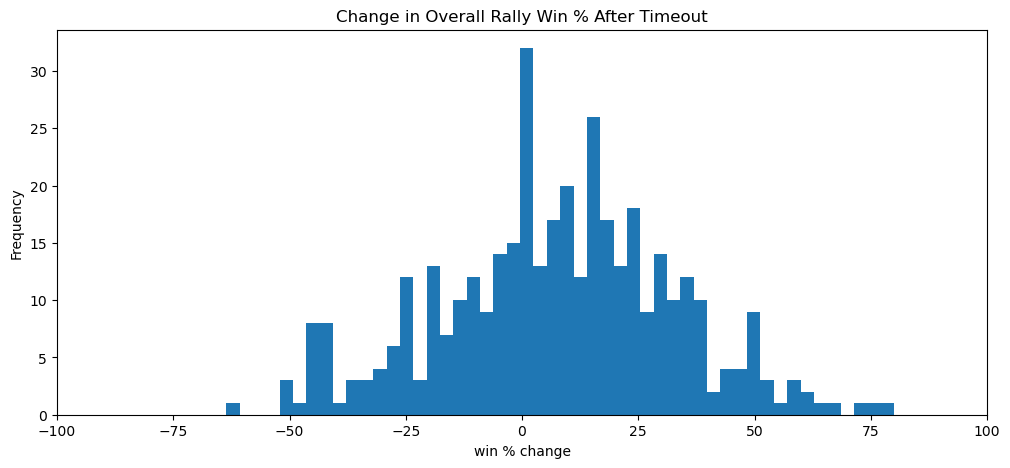

In [222]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(df_timeout.deltawin, bins=50)
plt.gca().set(title='Change in Overall Rally Win % After Timeout',xlim=[-100,100], xlabel = 'win % change', ylabel='Frequency');

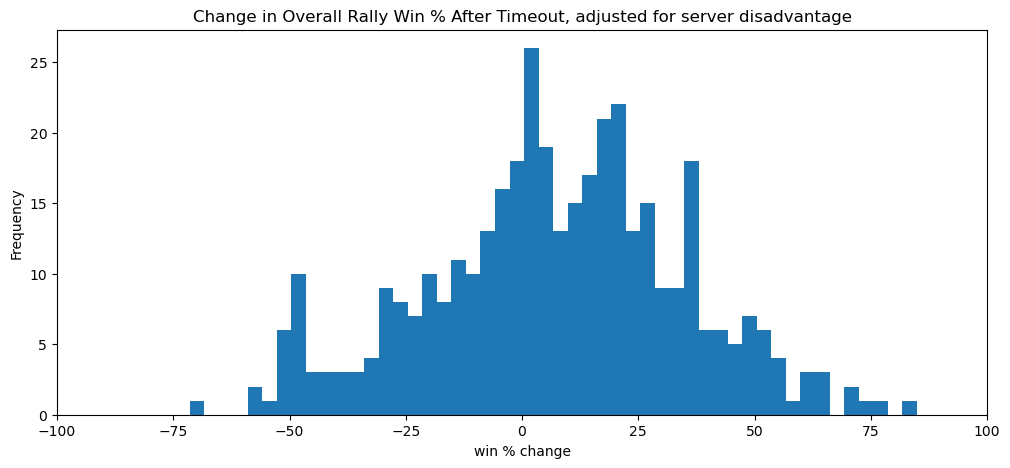

In [351]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(df_timeout.deltawin_adj, bins=50)
plt.gca().set(title='Change in Overall Rally Win % After Timeout, adjusted for server disadvantage',xlim=[-100,100], xlabel = 'win % change', ylabel='Frequency');

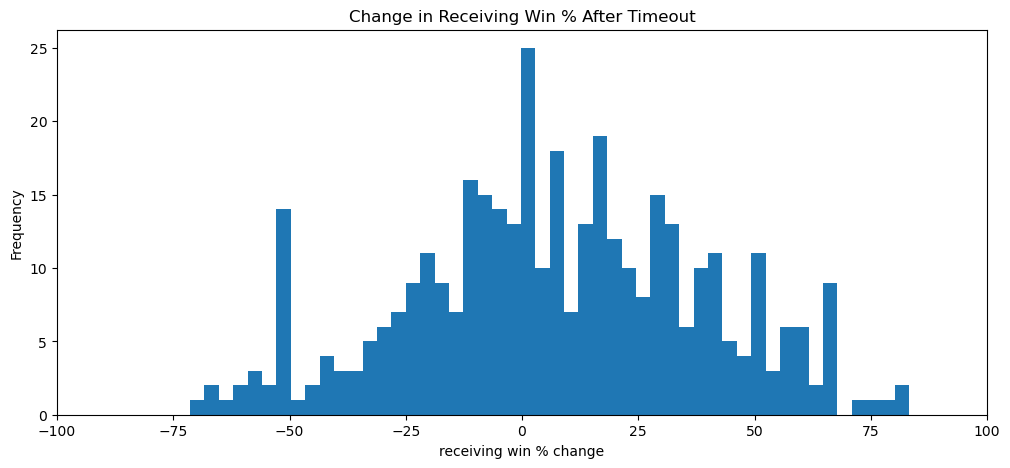

In [223]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(df_timeout.deltawinrcv, bins=50)
plt.gca().set(title='Change in Receiving Win % After Timeout', xlim=[-100,100],xlabel = 'receiving win % change', ylabel='Frequency');

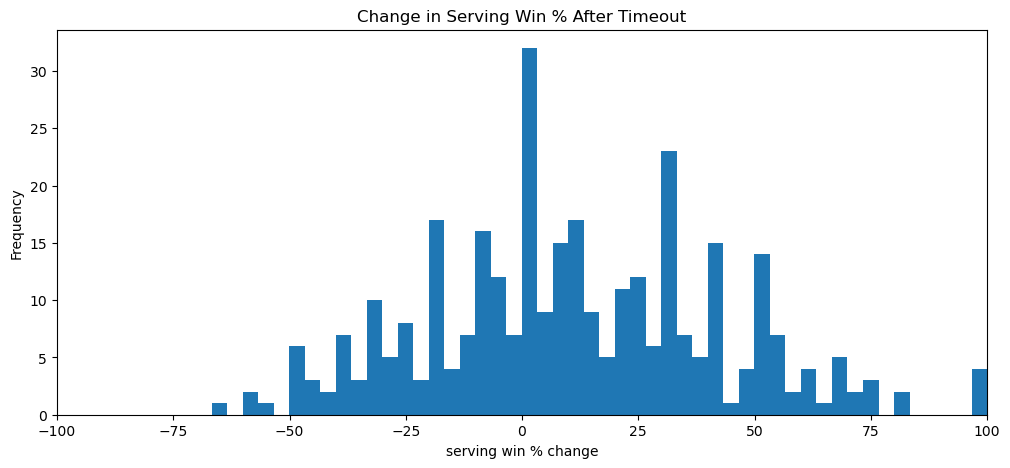

In [224]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(df_timeout.deltawinsrv, bins=50)
plt.gca().set(title='Change in Serving Win % After Timeout', xlim=[-100,100],xlabel = 'serving win % change', ylabel='Frequency');

## Group plots by skill level

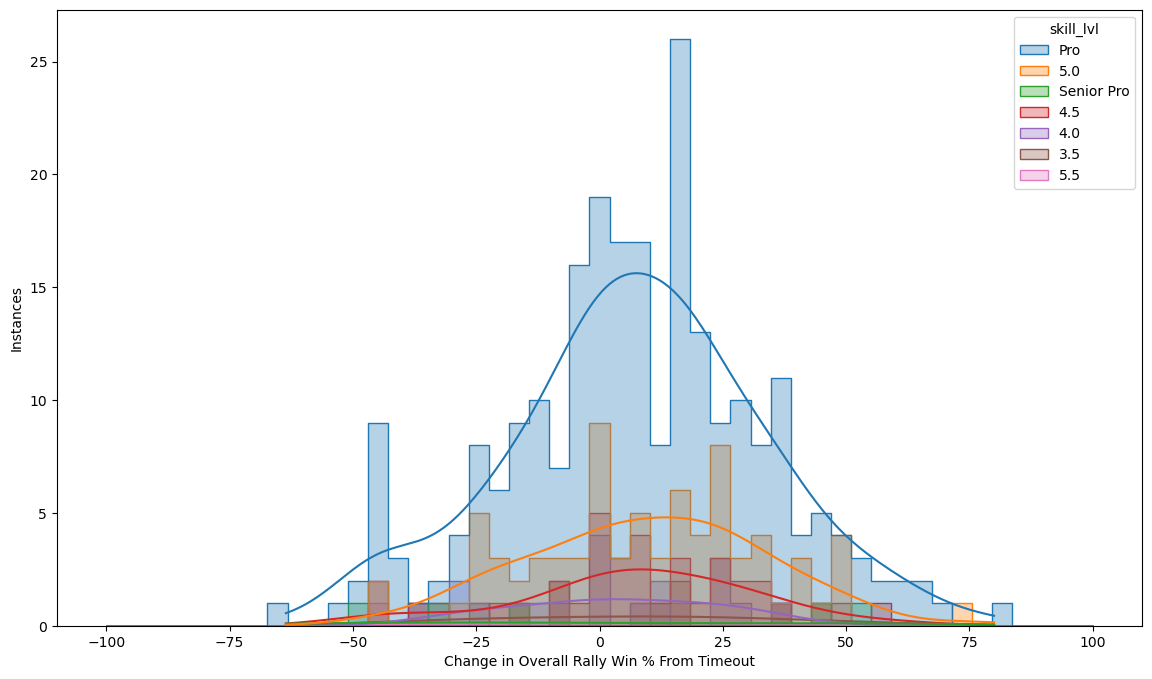

In [225]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-100, 100, 50)
p = sns.histplot(x="deltawin",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in Overall Rally Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

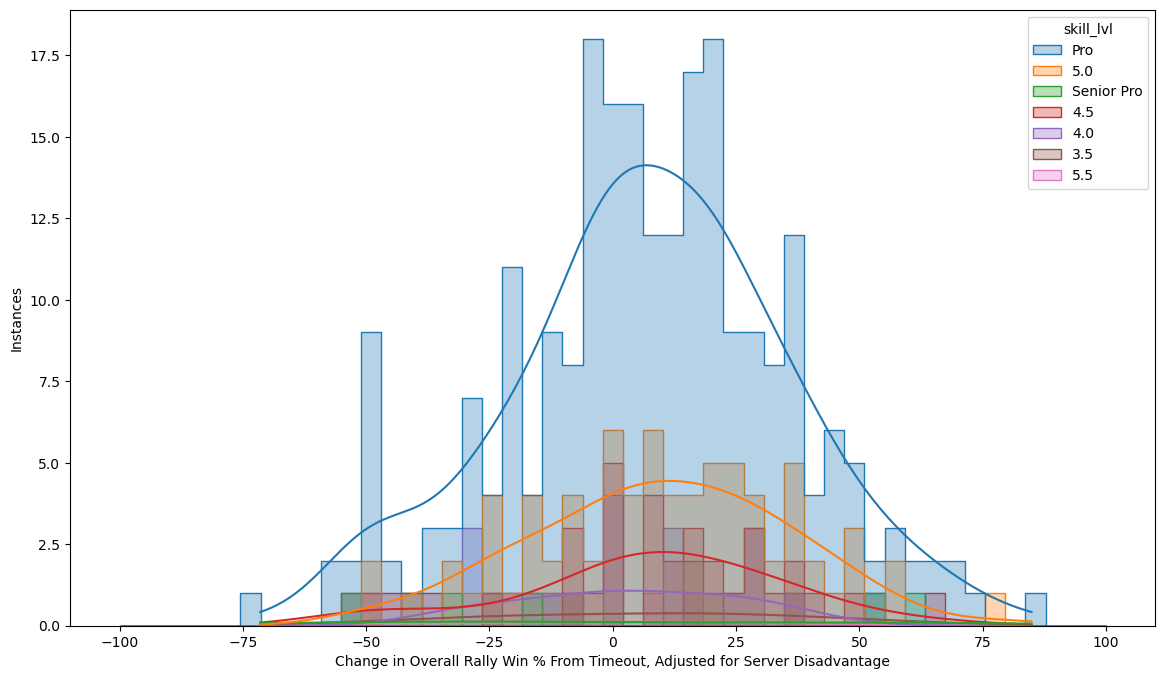

In [352]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-100, 100, 50)
p = sns.histplot(x="deltawin_adj",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in Overall Rally Win % From Timeout, Adjusted for Server Disadvantage",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

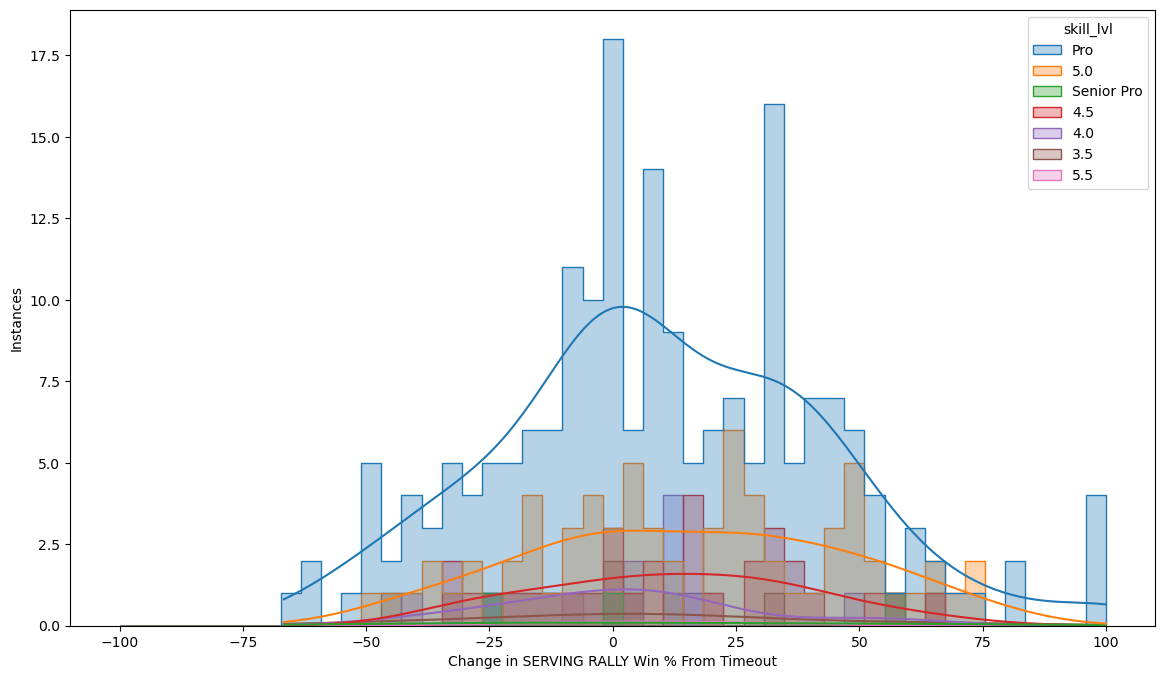

In [226]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-100, 100, 50)
p = sns.histplot(x="deltawinsrv",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in SERVING RALLY Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

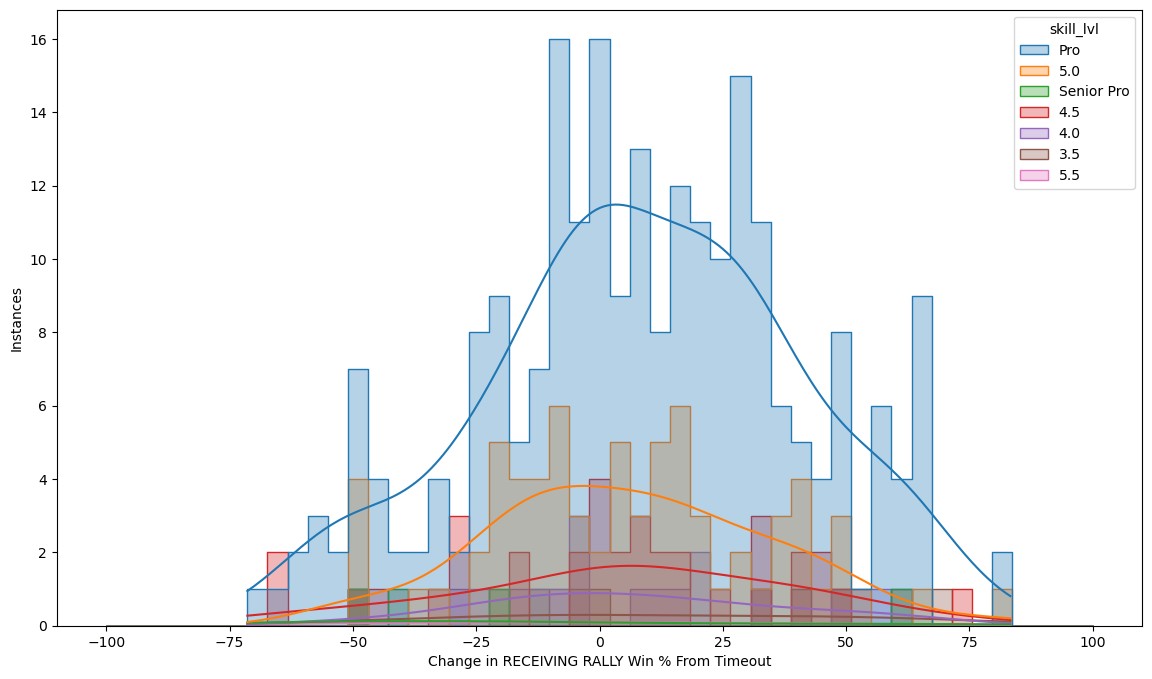

In [227]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-100, 100, 50)
p = sns.histplot(x="deltawinrcv",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in RECEIVING RALLY Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

In [354]:
df_pro=df_timeout[df_timeout.skill_lvl == 'Pro']
df_senpro=df_timeout[df_timeout.skill_lvl == 'Senior Pro']
df_35=df_timeout[df_timeout.skill_lvl == '3.5']
df_40=df_timeout[df_timeout.skill_lvl == '4.0']
df_45=df_timeout[df_timeout.skill_lvl == '4.5']
df_50=df_timeout[df_timeout.skill_lvl == '5.0']
df_55=df_timeout[df_timeout.skill_lvl == '5.5']
skilldata=[list(x.deltawin) for x in [df_35,df_40,df_45,df_50,df_55,df_pro,df_senpro,df_timeout]]
skilldata_adj=[list(x.deltawin_adj) for x in [df_35,df_40,df_45,df_50,df_55,df_pro,df_senpro,df_timeout]]
skilldatasrv=[list(x['deltawinsrv'][~pd.isna(x.deltawinsrv)]) for x in [df_35,df_40,df_45,df_50,df_55,df_pro,df_senpro,df_timeout]]
skilldatarcv=[list(x['deltawinrcv'][~pd.isna(x.deltawinrcv)] )for x in [df_35,df_40,df_45,df_50,df_55,df_pro,df_senpro,df_timeout]]

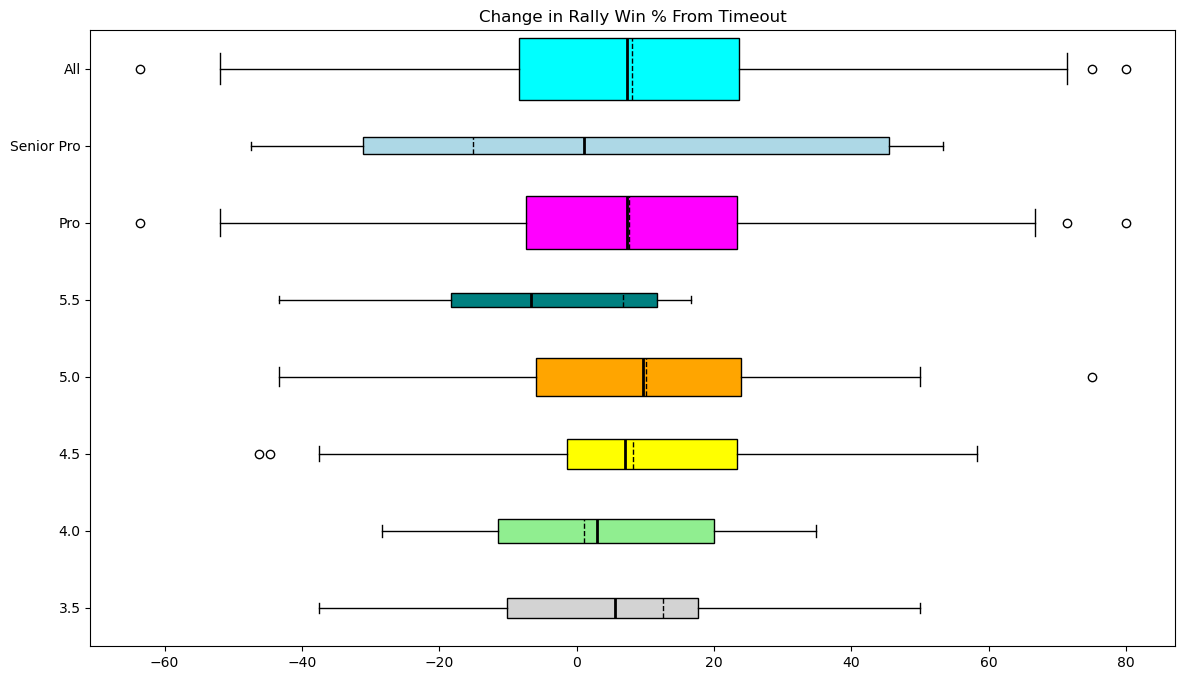

In [229]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')

plt.title("Change in Rally Win % From Timeout")
# Define widths for boxplots as 0.8 of the normalized sample size
sample_sizes=[len(skilldata[x]) for x in range(len(skilldata))]
widths = [.8*(s / max(sample_sizes))**.3 for s in sample_sizes]

box = plt.boxplot(skilldata,widths=widths,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['3.5','4.0','4.5','5.0','5.5','Pro','Senior Pro','All'])

colors = ['lightgrey','lightgreen','yellow','orange','teal','magenta','lightblue','cyan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

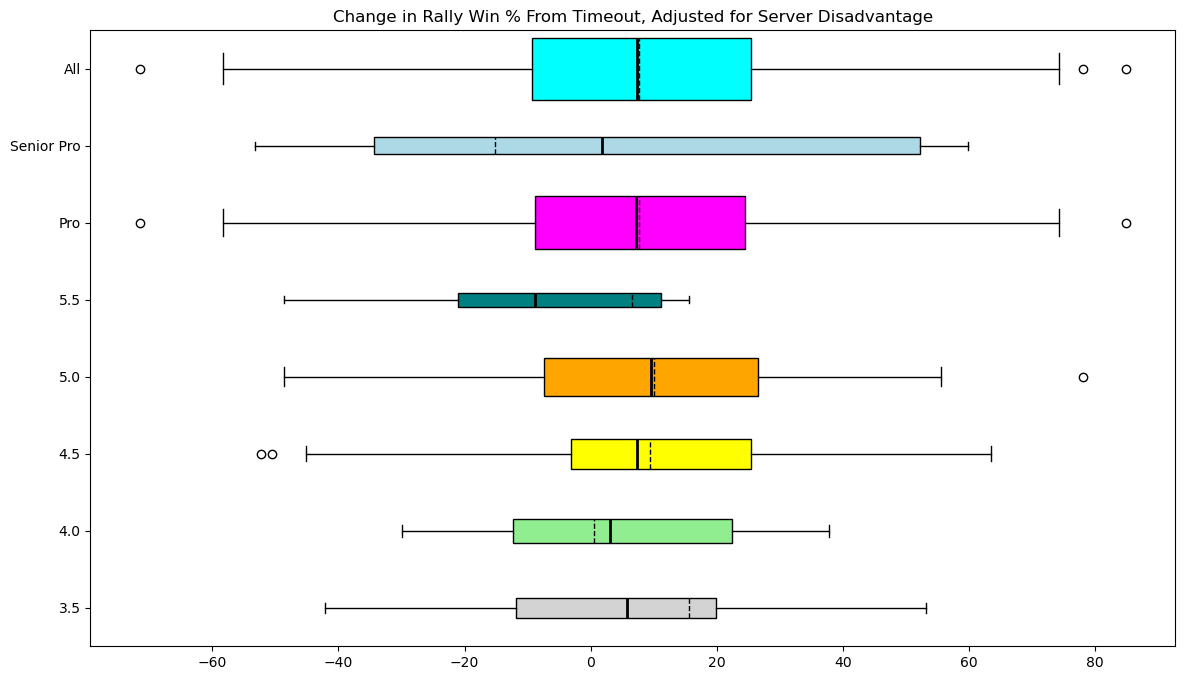

In [356]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')

plt.title("Change in Rally Win % From Timeout, Adjusted for Server Disadvantage")
# Define widths for boxplots as 0.8 of the normalized sample size
sample_sizes=[len(skilldata_adj[x]) for x in range(len(skilldata_adj))]
widths = [.8*(s / max(sample_sizes))**.3 for s in sample_sizes]

box = plt.boxplot(skilldata_adj,widths=widths,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['3.5','4.0','4.5','5.0','5.5','Pro','Senior Pro','All'])

colors = ['lightgrey','lightgreen','yellow','orange','teal','magenta','lightblue','cyan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

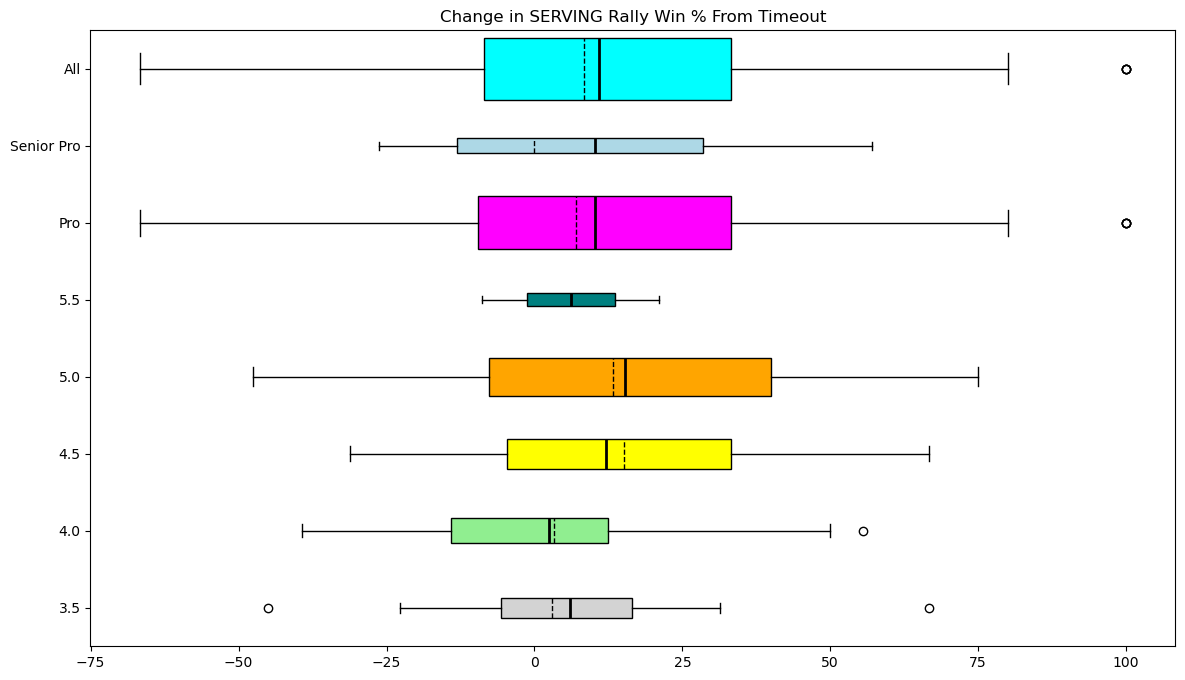

In [230]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')

plt.title("Change in SERVING Rally Win % From Timeout")
sample_sizes=[len(skilldatasrv[x]) for x in range(len(skilldatasrv))]
widths = [.8*(s / max(sample_sizes))**.3 for s in sample_sizes]

box = plt.boxplot(skilldatasrv,widths=widths,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['3.5','4.0','4.5','5.0','5.5','Pro','Senior Pro','All'])

colors = ['lightgrey','lightgreen','yellow','orange','teal','magenta','lightblue','cyan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

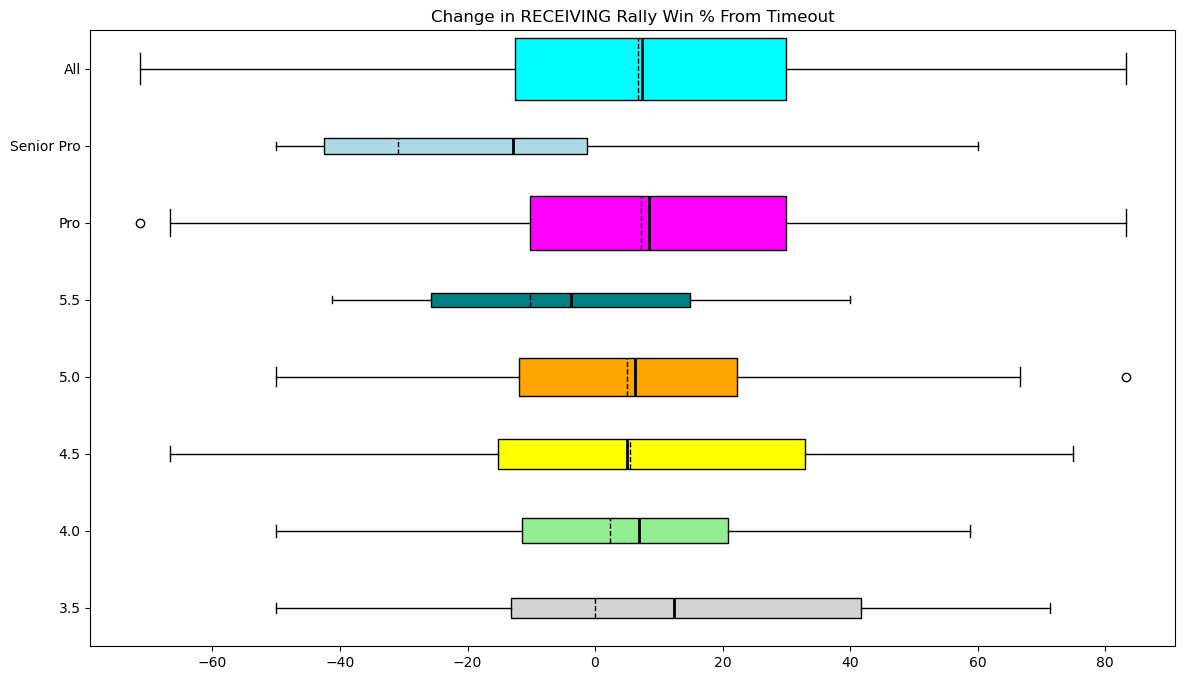

In [231]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')

plt.title("Change in RECEIVING Rally Win % From Timeout")
sample_sizes=[len(skilldatarcv[x]) for x in range(len(skilldatarcv))]
widths = [.8*(s / max(sample_sizes))**.3 for s in sample_sizes]

box = plt.boxplot(skilldatarcv,widths=widths,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['3.5','4.0','4.5','5.0','5.5','Pro','Senior Pro','All'])

colors = ['lightgrey','lightgreen','yellow','orange','teal','magenta','lightblue','cyan']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.show()